## Второй этап

Теперь нам известна эволюционно устойчивая стратегия поведения $x=A+Bcos(2\pi \cdot t)$
$$A=-85, B=-50$$
Составим вектор вертикальны
$$x^*=(x(0), x(\frac{1}{n}), x(\frac{2}{n}),...,x(\frac{n}{n}))$$
$$t\in(0,1)$$

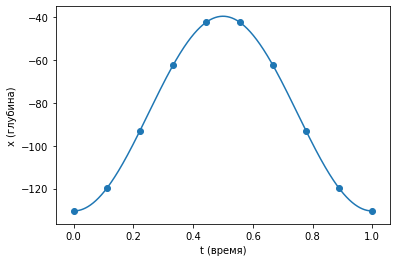

In [663]:
import numpy as np
import matplotlib.pyplot as plt 


A = -84.95
B = -45.5
C0 = 60
C = 140

def x(t):
    return A + B * np.cos(2 * np.pi * t)

n = 10

t_space_n = np.linspace(0, 1, n)
t_space_real = np.linspace(0, 1, 1000)
x_star = [x(t) for t in t_space_n]

plt.plot(t_space_real, x(t_space_real))
plt.scatter(t_space_n, x_star)
plt.xlabel('t (время)')
plt.ylabel('x (глубина)')
plt.show()

Сгенерируем новые стратегии поведения по такому принципу:

Выберем случайное число от 1 до $n$, обозначим его $k$. Теперь выберем $k$ случайных различных чисел $m_i$, $i=1,..k$ от $m_i \in \{1,...,n\}$ и проведем случайные сдвиги $c_{m_i}$ по координатам $x_{m_i}$. Таким образом генерируется новая стратегия поведения.  

In [664]:
import pandas as pd

numbers = [i for i in range(n)]
state = np.random.RandomState(12345)


def gen_k_numbers(k):
    m = pd.Series(numbers).sample(n=k, random_state=state)
    return list(m)


def plot_wave(wave):
    for i in range(len(wave)):
        plt.plot(t_space_n, wave[i])
    plt.xlabel('t (время)')
    plt.ylabel('x (глубина)')
    plt.title('Генерация одной волны')
    plt.show()

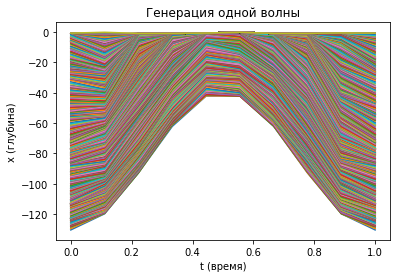

In [665]:
from sklearn.metrics import mean_squared_error
def gen_one(x, m, eps):
    for i in range(len(m)):
        x[m[i]] += eps * np.random.random()
        if m[i] == 0:
            x[len(x) - 1] = x[m[i]]
    return x

def numbers_can_changed(x, eps):
    numbers = []
    for i in range(len(x) - 1):
        if (eps > 0 and x[i] < -eps) or (eps < 0 and x[i] > -C - eps):
            numbers.append(i)
    return numbers

def gen_func_wave_2(eps, n_iter):
    wave = []
    x = x_star
    numbers = numbers_can_changed(x, eps)
    wave.append(x)
    i = 0
    while numbers != [] and i < n_iter:
        k = np.random.randint(1, len(numbers) + 1, size=1)
        m = list(pd.Series(numbers).sample(n=k, random_state=state))
        x = gen_one(x[:], m, eps)
        wave.append(x)
        numbers = numbers_can_changed(x, eps)
        i += 1
    return wave


def check1(u, v):
    u = pd.Series(u)
    v = pd.Series(v)
    if np.prod(u - v == 0) == 1:
        return False
    if np.prod(u - v >= 0) == 1:
        return -1
    if np.prod(u - v <= 0) == 1:
        return 1
    return False

def check(u, v):
    k = [0] * len(u)
    
    for i in range(len(u)):
        k[i] = u[i] - v[i]
    ok_1 = True
    for elem in k:
        if elem < 0:
            ok_1 = False
            break
    ok_0 = True
    for elem in k:
        if elem > 0:
            ok_0 = False
            break
    zero = True
    for elem in k:
        if elem != 0:
            zero = False
    if zero:
        return False
    if ok_0:
        return 1
    if ok_1:
        return -1
    return False

def check_mse(u, v):
    mse_u = mean_squared_error(u, x_star)
    mse_v = mean_squared_error(v, x_star)
    if mse_u < mse_v:
        return 1
    elif mse_u > mse_v:
        return -1
    return False


def get_l_waves2(l, m, check_func, use_all=True, eps=1):

    wave_plus = []
    wave_minus = []
    for i in range(l):
        wave1 = gen_func_wave_2((-1) ** i * eps, m)
        wave2 = gen_func_wave_2((-1) ** (i + 1) * eps, m)
        
        if i % 2 == 0:
            wave_plus += wave1[:]
            wave_minus += wave2[:]
            
        else:
            wave_plus += wave2[:]
            wave_minus += wave1[:]
    strats = []     
    if use_all:
        all_waves = wave_plus + wave_minus
        for i in range(len(wave_plus)):
            for j in range(i + 1, len(wave_plus)):
                cl = check_func(wave_plus[i], wave_plus[j])
                if cl is not False:
                    strats.append((all_waves[i], all_waves[j], cl))
                    strats.append((all_waves[j], all_waves[i], -cl))
    else:
        for i in range(len(wave_plus)):
            for j in range(i + 1, len(wave_plus)):
                cl = check_func(wave_plus[i], wave_plus[j])
                if cl is not False:
                    strats.append((wave_plus[i], wave_plus[j], cl))
                    strats.append((wave_plus[j], wave_plus[i], -cl))
        for i in range(len(wave_minus)):
            for j in range(i + 1, len(wave_minus)):
                cl = check_func(wave_minus[i], wave_minus[j])
                if cl in [-1, 1]:
                    strats.append((wave_minus[i], wave_minus[j], cl))
                    strats.append((wave_minus[j], wave_minus[i], -cl))

    return strats

                

wave = gen_func_wave_2(1, 20000)   
plot_wave(wave)

In [666]:
def gen_rand(l, check_func):
    all_waves = []
    for i in range(l):
        x_new_1 = [0] * n
        x_new_2 = [0] * n
        for j in range(n):
            x_new_1[j] = np.random.randint(-C, x_star[j])
            x_new_2[j] = np.random.randint(x_star[j], 0)
        all_waves.append(x_new_1[:])
        all_waves.append(x_new_2[:])
    
    strats = []
    for i in range(len(all_waves)):
        for j in range(i + 1, len(all_waves)):
            cl = check_func(all_waves[i], all_waves[j])
            strats.append((all_waves[i], all_waves[j], cl))
            strats.append((all_waves[j], all_waves[i], -cl))
    plot_wave(all_waves)
    return strats

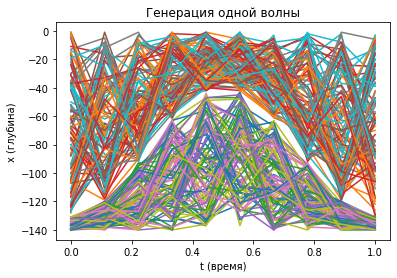

39800


In [667]:
#strats = get_l_waves2(10, 100, check_func=check1, use_all = True, eps=15)
strats = gen_rand(100, check_mse)
print(len(strats))

## Напишем функции подсчета интегралов
$$
R(x) = \int\limits_0^1 \alpha E(x)\,dt - \int\limits_0^1 \gamma S_x(x) (cos(2\pi t) + 1)\,dt - \int\limits_0^1 \beta (x')^2\,dt  - \int\limits_0^1 \delta G(x)\,dt 
$$ где $x$ - стратегия поведения.

$$
R(u) = \int\limits_0^1 \alpha E(u)\,dt - \int\limits_0^1 \gamma S_x(u) (cos(2\pi t) + 1)\,dt - \int\limits_0^1 \beta (u')^2\,dt  - \int\limits_0^1 \delta G(u)\,dt \\
R(v) = \int\limits_0^1 \alpha E(v)\,dt - \int\limits_0^1 \gamma S_x(v) (cos(2\pi t) + 1)\,dt - \int\limits_0^1 \beta (v')^2\,dt  - \int\limits_0^1 \delta G(v)\,dt \\
R(u) - R(v) = \alpha\int\limits_0^1  (E(u) - E(v)\,dt - \gamma \int\limits_0^1 (S_x(u) (cos(2\pi t) + 1)) - (S_x(v) (cos(2\pi t) + 1))\,dt -\beta \int\limits_0^1  ((u')^2 - (v')^2)\,dt  - \delta\int\limits_0^1  (G(u) - G(v))\,dt 
$$
Аппроксимации функций состояния окружающей среды:

$$E = \sigma_1 (x + C), -C < x < 0 \\
S_x = \sigma_2 (x + C) \\
S_t=cos(2\pi t) + 1, 0 < t < 1 \\
G = (x + C_0)^2
$$

In [668]:
sigm1 = 0.25
sigm2 = 0.003



def E(x, t):
    return sigm1 * (x + C)

def S_x_S_t(x, t):
    return sigm2 * (x + C) * (np.cos(2 * np.pi * t) + 1)

def G(x, t):
    return (x + C0) * (x + C0)

def integr(f, x):
    res = 0
    for i in range(len(x) - 1):
        res += (f(x[i + 1], (i + 1) / n) + f(x[i], i / n)) / (2 * n)
    return res


    
def M_0(x):
    return integr(E, x)

def M_1(x):
    return -integr(S_x_S_t, x)

def M_2(x):
    res = 0
    x_2 = []
    for i in range(len(x) - 1):
        x_2.append(((x[i + 1] - x[i]) * n) * ((x[i + 1] - x[i]) * n))
    x_2.append(x_2[0])
    for i in range(len(x_2) - 1):
        res += (x_2[i] + x_2[i + 1]) / (2 * n)
    return -res

def M_3(x):
    return -integr(G, x)

def M(x):
    return M_0(x), M_1(x), M_2(x), M_3(x)

Принцип сравнения:
Возьмем две стратегии поведения $u$ и $v$. Можно посчитать отклонение от эволюционно устойчивой стратегии поведения $x^*$. $\epsilon_1 = u - x^*$, $\epsilon_2 = v - x^*$. И сравнить отклонения $\epsilon_1 - \epsilon_2 = u - v$. Если $\epsilon_1 - \epsilon_2 > 0$, значит отклонение $u$ от эволюционно устойчивой стратегии поведения $x^*$ больше, чем отклонение $v$ от $x^*$. Следовательно $v$ более приспособлена, чем $u$, т.к. находится 'ближе' к $x^*$.

In [669]:
import pandas as pd

def get_params(strat):
    u = strat[0]
    v = strat[1]
    return [*(np.array(M(u)) - np.array(M(v))), strat[2]]
    
    
def gen_data_train(strats):
    train_data_arr = []
    for i in range(len(strats)):
        train_data_arr.append(get_params(strats[i]))
    train_data_classifier = pd.DataFrame(columns=['M_0', 'M_1', 'M_2', 'M_3', 'y'], data=train_data_arr)
    return train_data_classifier
    
data_train_classifier = gen_data_train(strats)
data_train_classifier['y'].value_counts()

-1    19900
 1    19900
Name: y, dtype: int64

<Figure size 1440x1440 with 0 Axes>

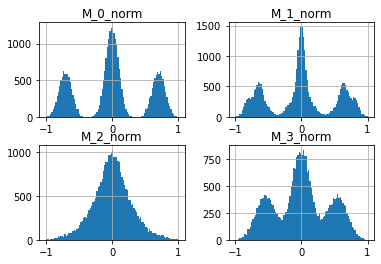

M_0       M_1       M_2       M_3
M_0  1.000000 -0.989802 -0.622875  0.940203
M_1 -0.989802  1.000000  0.610823 -0.922659
M_2 -0.622875  0.610823  1.000000 -0.481613
M_3  0.940203 -0.922659 -0.481613  1.000000

In [670]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.model_selection import train_test_split


def normalize(X):
    max_M = [0] * 4;
    X_norm = pd.DataFrame()
    max_M[0] = max(X['M_0'])
    max_M[1] = max(X['M_1'])
    max_M[2] = max(X['M_2'])
    max_M[3] = max(X['M_3'])
    X_norm['M_0_norm'] = X['M_0'] / max_M[0]
    X_norm['M_1_norm'] = X['M_1'] /  max_M[1]
    X_norm['M_2_norm'] = X['M_2'] /  max_M[2]
    X_norm['M_3_norm'] = X['M_3'] /  max_M[3]
    return X_norm, max_M

def normalized(X, max_M):
    X_norm = pd.DataFrame()
    max_M[0] = max(X['M_0'])
    max_M[1] = max(X['M_1'])
    max_M[2] = max(X['M_2'])
    max_M[3] = max(X['M_3'])
    X_norm['M_0_norm'] = X['M_0'] / max_M[0]
    X_norm['M_1_norm'] = X['M_1'] /  max_M[1]
    X_norm['M_2_norm'] = X['M_2'] /  max_M[2]
    X_norm['M_3_norm'] = X['M_3'] /  max_M[3]
    return X_norm


X = data_train_classifier.drop('y', axis=1)
y = data_train_classifier['y']

X, X_test, y, y_test = train_test_split(X, y, test_size=0.25)



X_normalized, max_M = normalize(X)
X_test_norm = normalized(X_test, max_M)

plt.figure(figsize=(20, 20))
X_normalized.hist(bins=100)
plt.show()
X.corr()

In [671]:
model_norm = Perceptron()
model_norm.fit(X_normalized, y)
"""
model_norm = Perceptron(max_iter=100000)
model_norm.fit(X_normalized, y, coef_init=[0,0,0,0])
model = Perceptron()
model.fit(X, y, coef_init=[0,0,0,0])
print()
"""

'\nmodel_norm = Perceptron(max_iter=100000)\nmodel_norm.fit(X_normalized, y, coef_init=[0,0,0,0])\nmodel = Perceptron()\nmodel.fit(X, y, coef_init=[0,0,0,0])\nprint()\n'

Веса модели с нормализаванными признаками  [9.58338141950373, 20.052265355363584, 0.14293927199006898, 9.138226198365722]
Веса исходной модели  [0.45418869286747543, 83.70736869983278, 4.30332586675304e-07, 0.0024905906621148837]
Истинные коэффициенты lam  [2, 333, 2.5e-05, 0.01]
Частота правильных ответов на обучающей выборке  0.8746733668341709
Косинус угла между векторами lam и model_coef 0.9999998317555843
Нормализованные веса модели [5.42583065e-03 9.99985280e-01 5.14084075e-09 2.97531034e-05]
Истинные нормализованные веса [6.00589768e-03 9.99981964e-01 7.50737210e-08 3.00294884e-05]


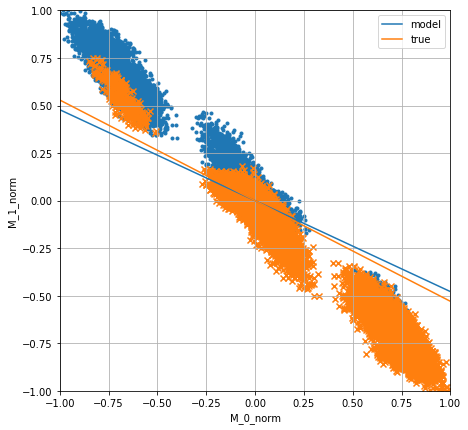

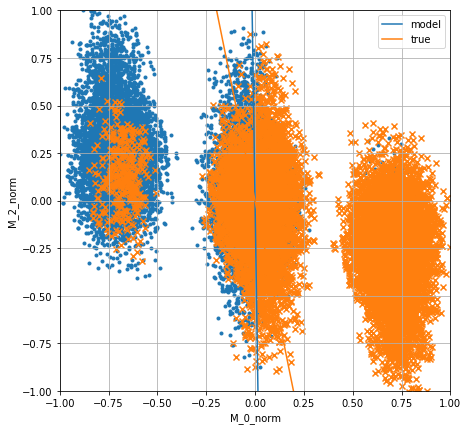

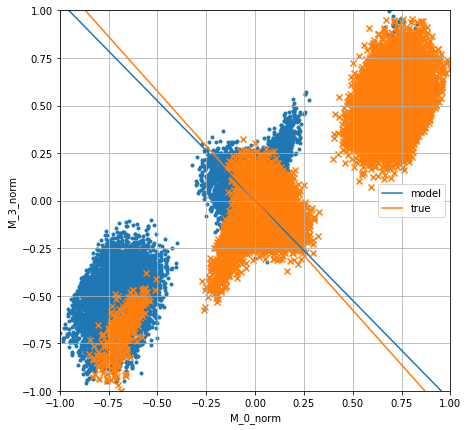

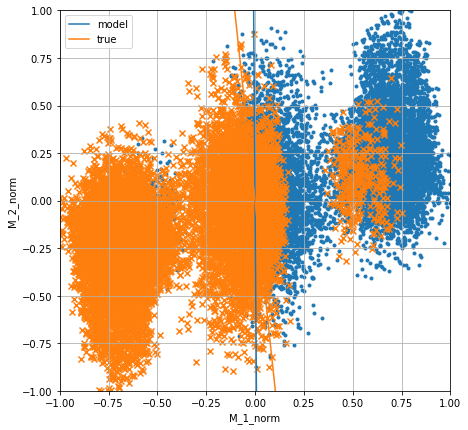

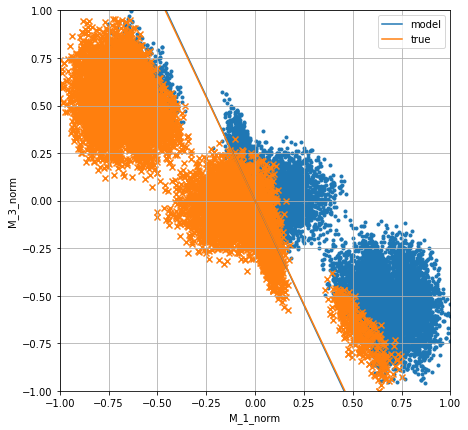

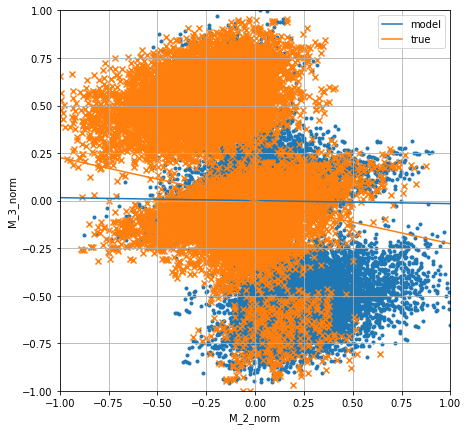

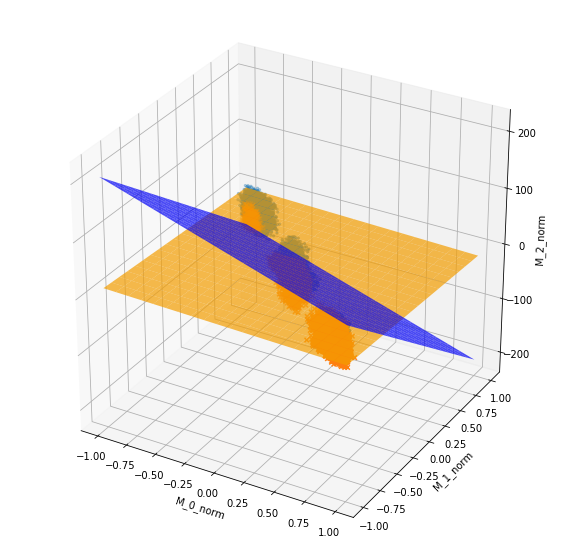

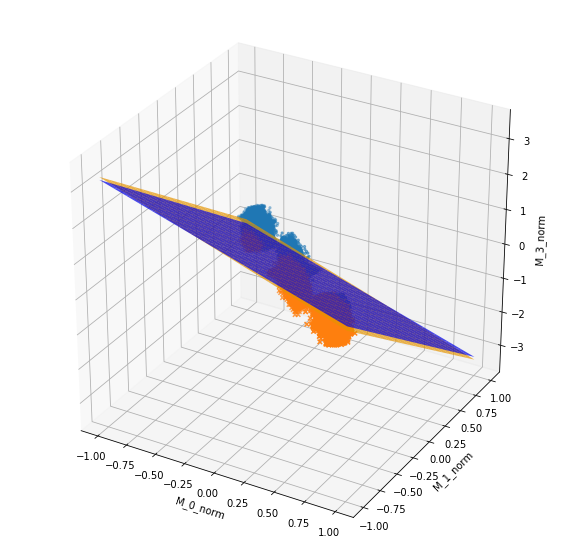

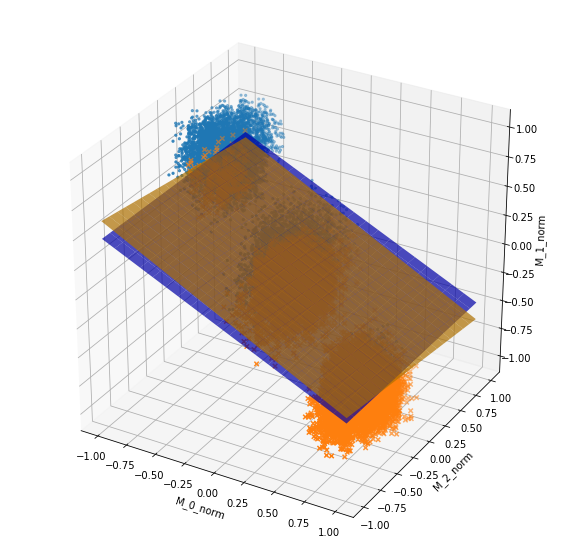

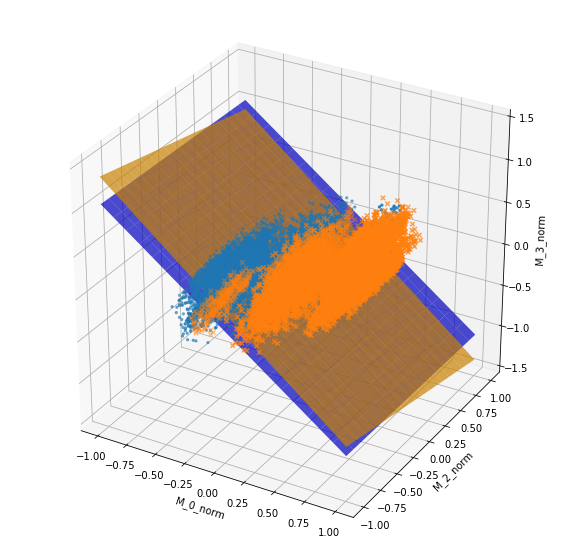

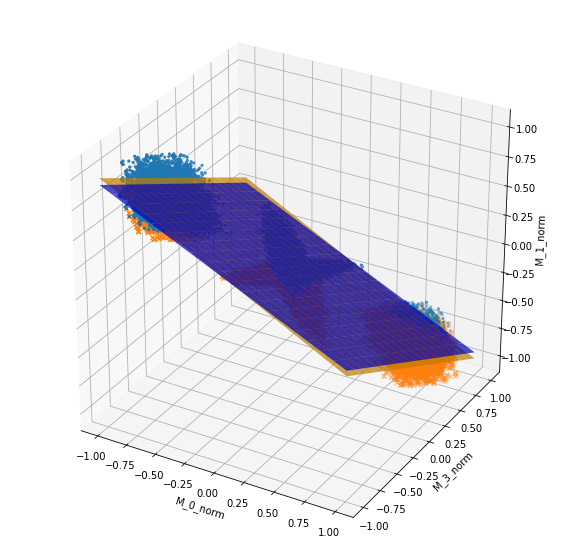

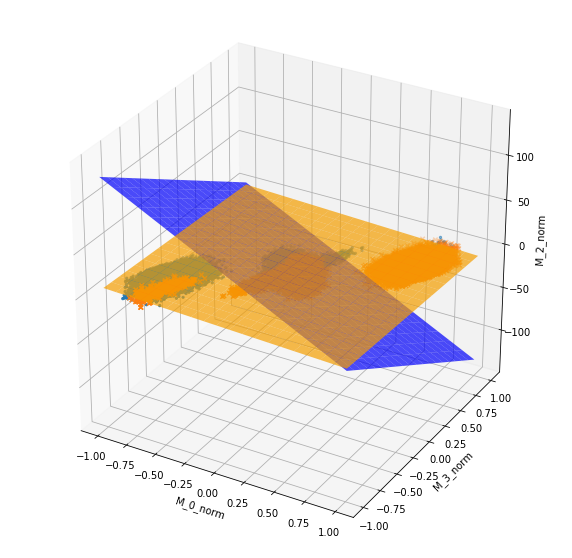

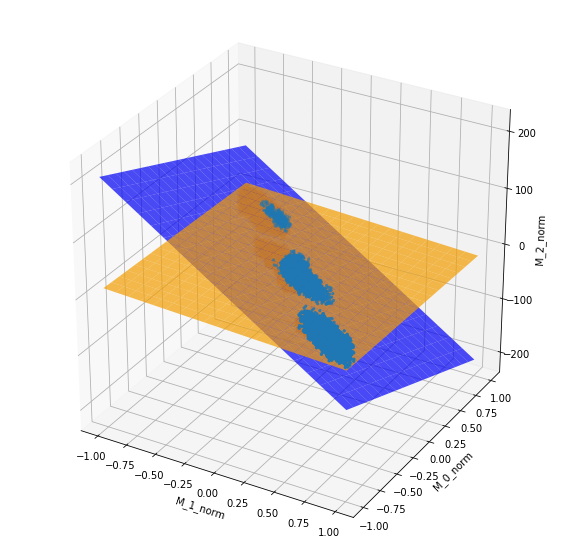

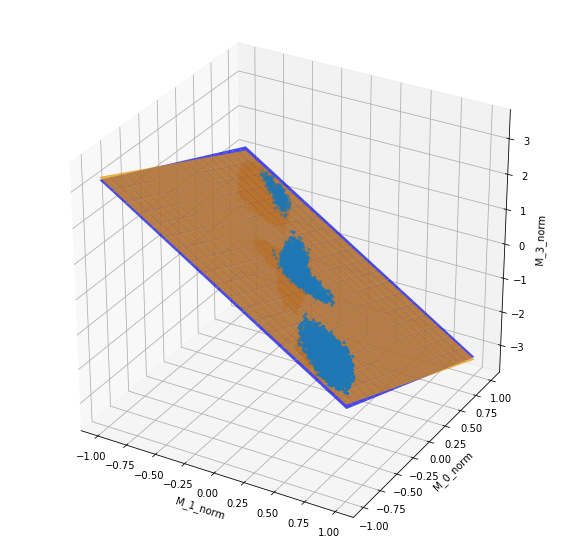

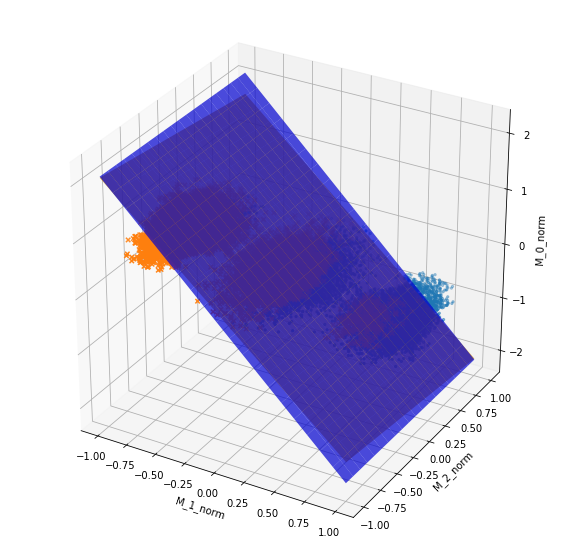

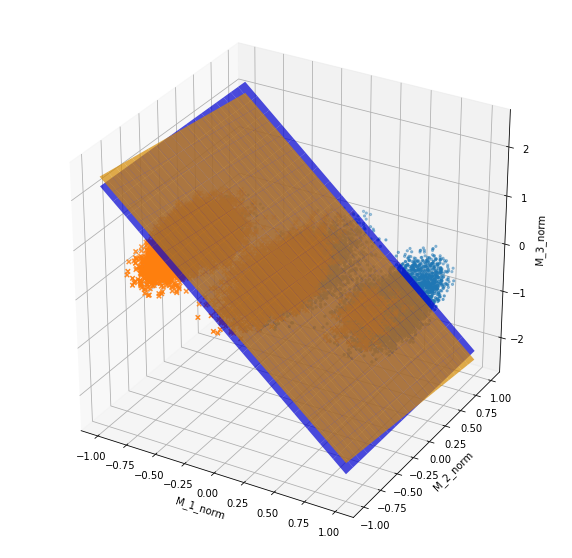

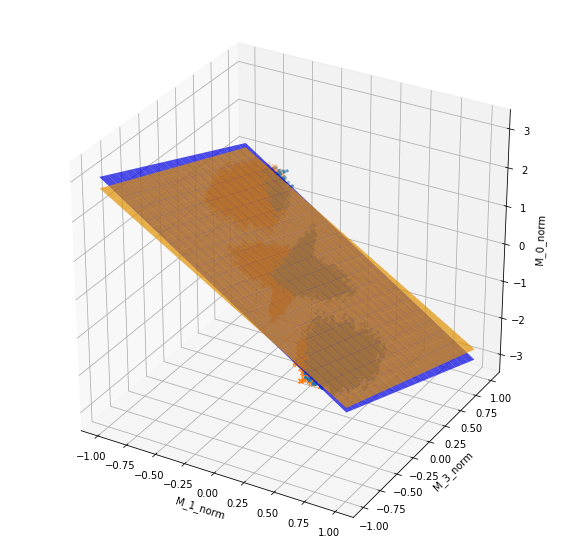

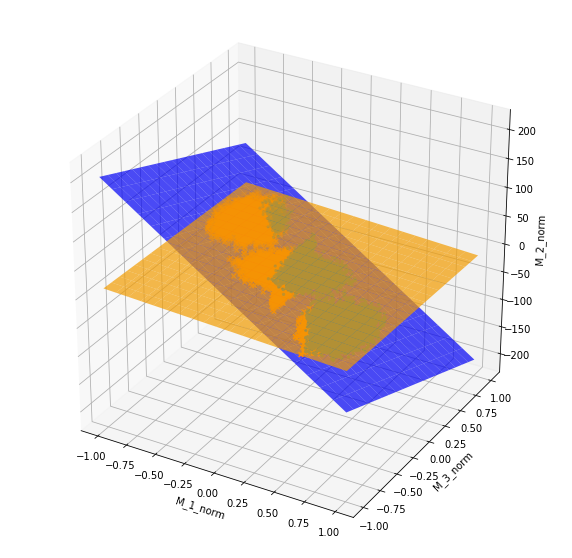

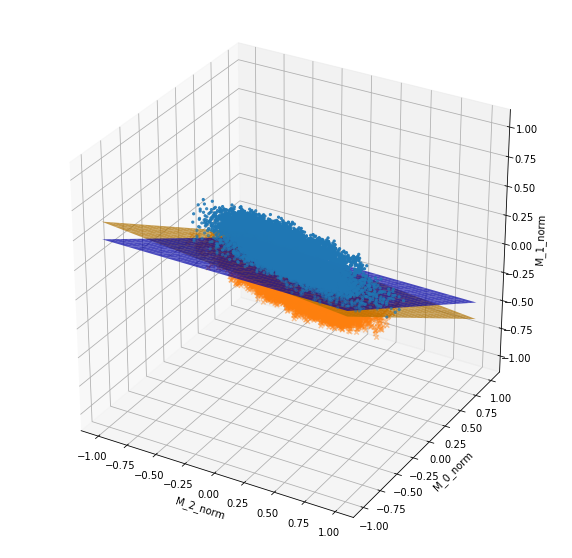

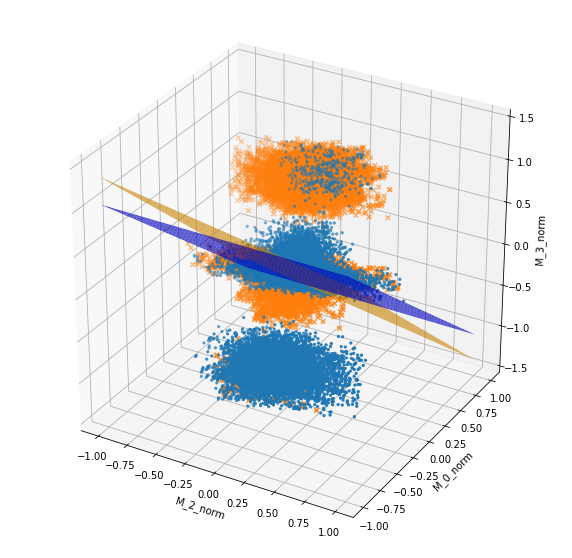

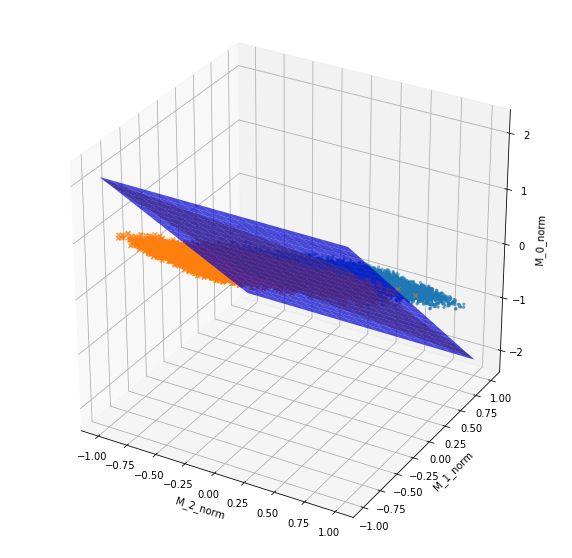

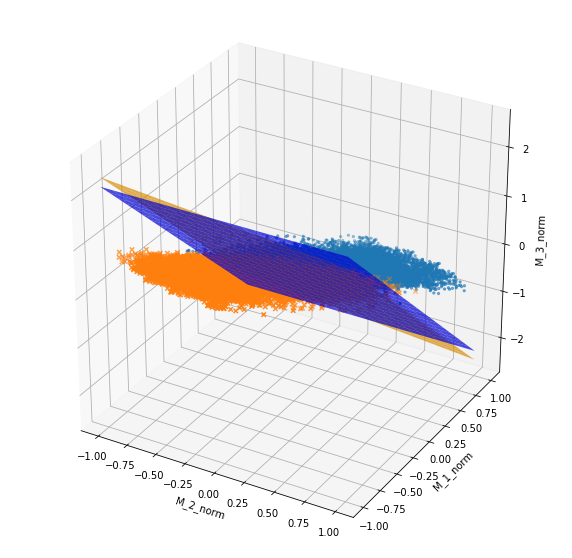

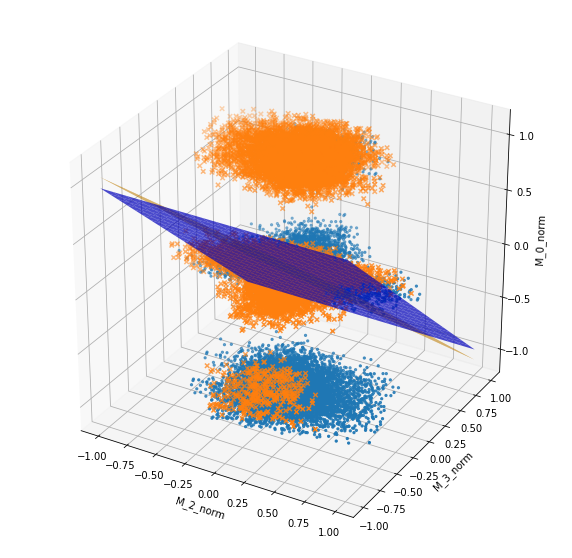

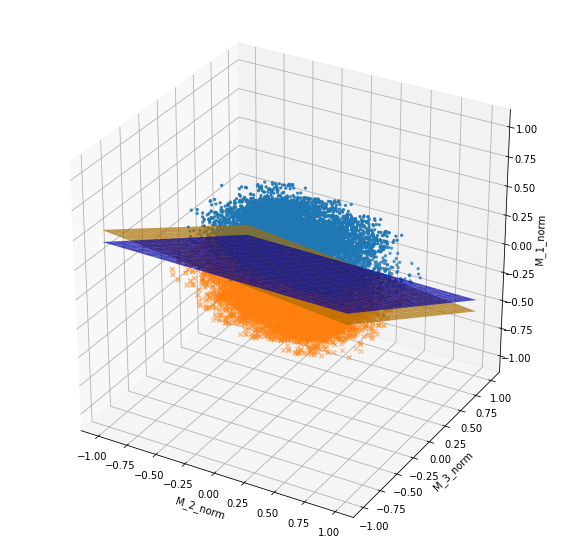

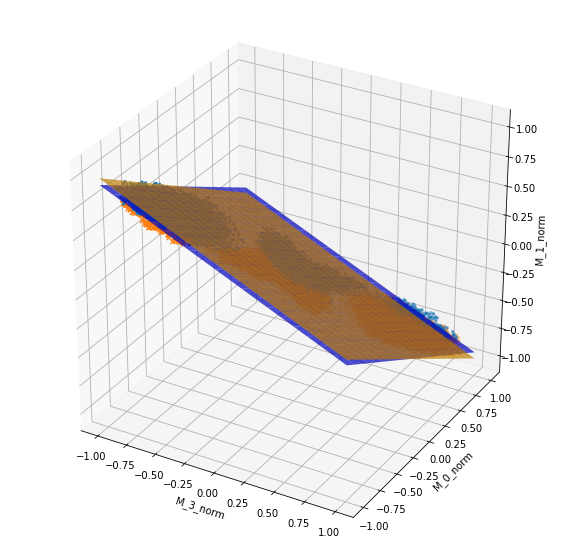

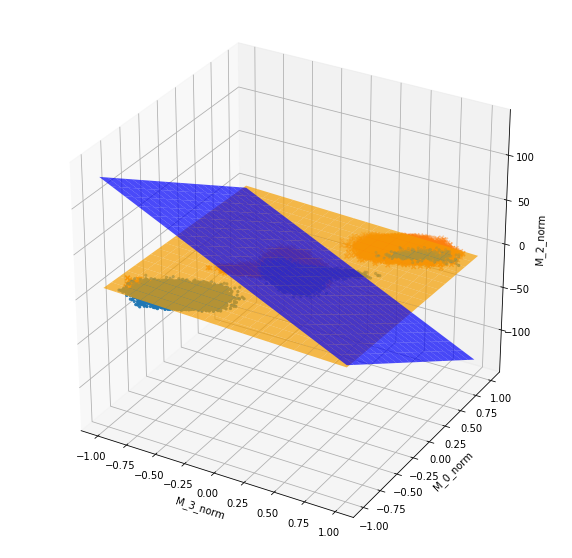

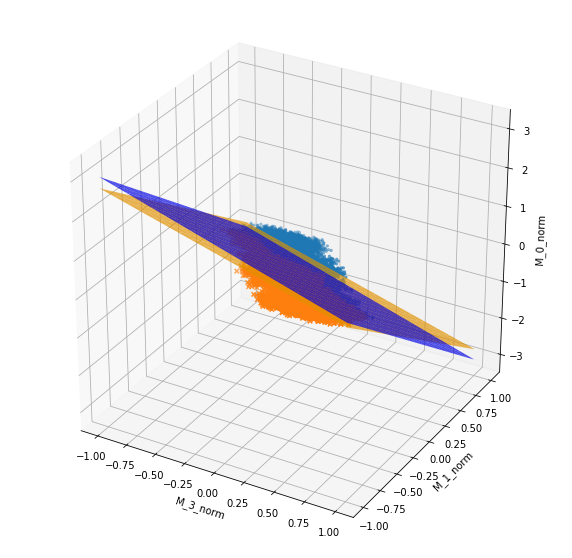

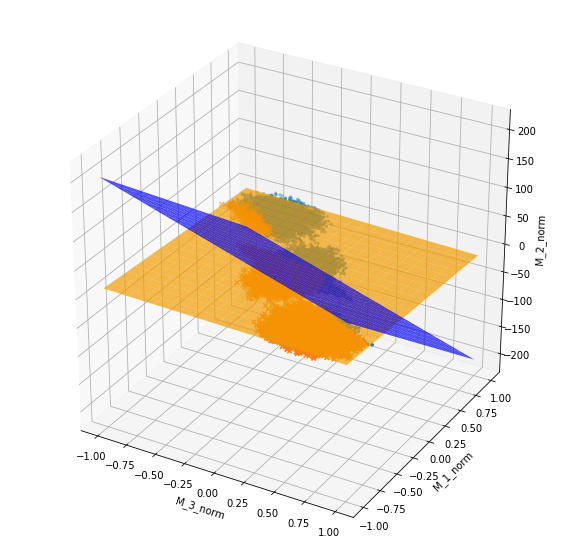

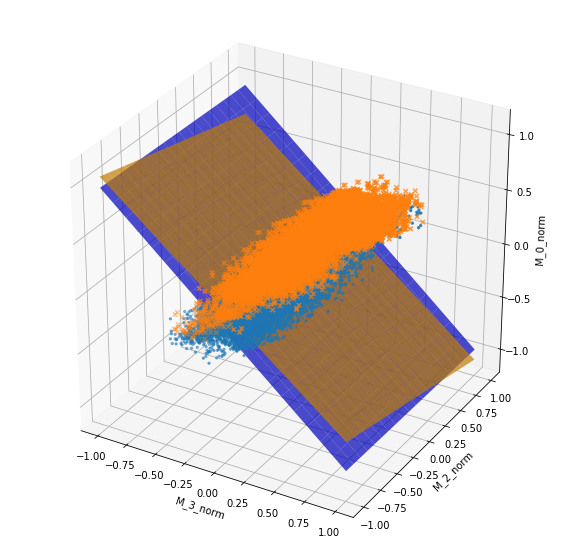

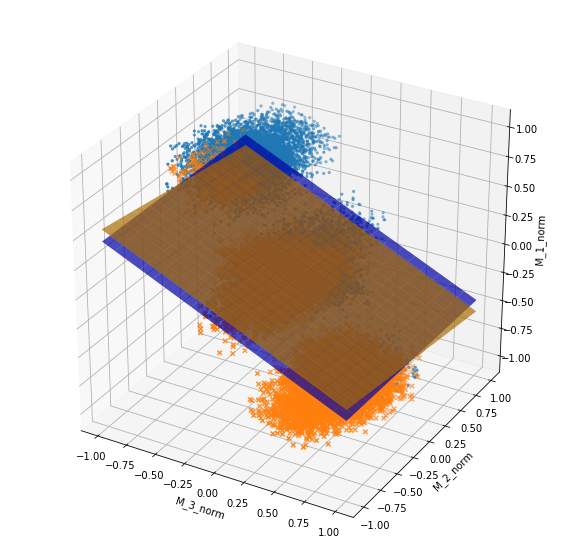

In [678]:
from mpl_toolkits.mplot3d import Axes3D

def module(u):
    ans = 0
    for elem in u:
        ans += elem * elem
    return ans

def sc(u, v):
    ans = 0;
    for i in range(len(u)):
        ans += u[i] * v[i];
    return ans;


def cos_n(u, v):
    return sc(u, v) / np.sqrt(module(u) * module(v))



def model_score(model, X, y, lam, show=False, max_M = [1, 1, 1, 1]):
    model_norm = list(model.coef_[0])
    print('Веса модели с нормализаванными признаками ', model_norm)
    model_coef = [0] * 4
    for i in range(4):
        model_coef[i] = model_norm[i] / max_M[i]
    print('Веса исходной модели ', model_coef)
    print('Истинные коэффициенты lam ', lam)
    print('Частота правильных ответов на обучающей выборке ', model.score(X, y))
    print('Косинус угла между векторами lam и model_coef', cos_n(model_coef, lam))
    print('Нормализованные веса модели', model_coef/ (module(model_coef)) ** 0.5)
    print('Истинные нормализованные веса', np.array(lam) / (module(lam)) ** 0.5)
    if show:
        X1 = X[y==1]
        X0 = X[y==-1]
        for i in range(len(X.columns)):
            for j in range(i + 1, len(X.columns)):
                x=np.linspace(-1, 1)
                plt.figure(figsize=(7, 7))
                plt.scatter(x = X1[X.columns[i]], y=X1[X.columns[j]], marker='.')
                plt.scatter(x = X0[X.columns[i]], y=X0[X.columns[j]], marker='x')
                plt.plot(x, (-1)* model_norm[i] / model_norm[j] * x, label='model')
                plt.plot(x, (-1) * (lam[i] * max_M[i]) / (lam[j] * max_M[j]) * x, label='true')
                plt.xlim(-1,1)
                plt.ylim(-1,1)
                plt.legend()
                plt.xlabel(X.columns[i])
                plt.ylabel(X.columns[j])
                plt.grid()
                plt.show()
        for i in range(len(X.columns)):
            for j in range(len(X.columns)):
                for k in range(len(X.columns)):
                    if i == j or j == k or i == k:
                        continue
                    u, v = np.mgrid[-1:1:20j, -1:1:20j]
                    fig = plt.figure(figsize=(10, 10))
                    ax = fig.add_subplot(111, projection='3d')
                    ax.scatter(X1[X.columns[i]], X1[X.columns[j]], X1[X.columns[k]], marker='.')
                    ax.scatter(X0[X.columns[i]], X0[X.columns[j]], X0[X.columns[k]], marker='x')
                    ax.plot_surface(u , v, (-1)* (model_norm[i] * u + model_norm[j] * v) / model_norm[k], alpha=0.7, color='blue')
                    ax.plot_surface(u , v, (-1)* ((lam[i] * max_M[i]) * u + (lam[j] * max_M[j]) * v) / (lam[k] * max_M[k]), alpha=0.7, color='orange')
                    ax.set_xlabel(X.columns[i])
                    ax.set_ylabel(X.columns[j])
                    ax.set_zlabel(X.columns[k])
                    plt.show()
    return model_coef
                

lam = [2, 333, 0.000025, 0.01]
#lam = [0.5 / sigm1, 1 / sigm2, 0.000025, 0.01]
model_lam = model_score(model_norm, X_normalized, y, lam, True,  max_M)

In [673]:
def A(lam):
    return (lam[0] * sigm1 - 2 * lam[3] * C0 - lam[1] * sigm2) / (2 * lam[3])

def B(lam):
    return -lam[1] * sigm2 / (2 * lam[3] + 2 * (2 * np.pi) *(2 * np.pi) * lam[2])

A_model, B_model = A(model_lam), B(model_lam)
A_true, B_true = A(lam), B(lam)
print('Model A, B',A_model, B_model)
print('True A, B', A_true, B_true)

Model A, B -87.6189369404059 -50.07261084439409
True A, B -84.94999999999999 -45.462983390431454


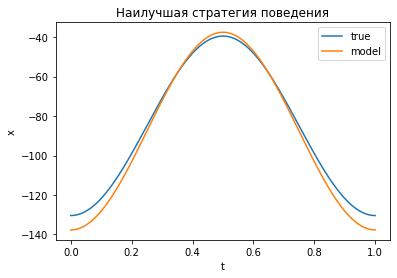

In [674]:
t_space = np.linspace(0, 1, 1001)

def x(A, B, t):
    return A + B * np.cos(2 * np.pi * t)

plt.plot(t_space, x(A_true, B_true, t_space), label='true')
plt.plot(t_space, x(A_model, B_model, t_space), label='model')
plt.legend()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Наилучшая стратегия поведения')
plt.show()

In [675]:
model_norm.score(X_test_norm, y_test)
model_norm

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [676]:
res = 0
X_test_norm = X_test_norm.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
for i in range(len(X_test_norm)):
    a = np.dot(X_test_norm.loc[i], lam)
    target = -1
    if a >= 0:
        target = 1
    if target == y_test[i]:
        res += 1
print(res / len(y_test))

0.7656281407035176


In [677]:
a = pd.Series([1, 2, 3])
b = pd.Series([2, 2, 3])
np.prod(np.array(a <= b))

1